In [1]:
import numpy as np
import torch
import torch.nn as nn
import cv2
import os

In [2]:
def adj_num(num):
    s = str(num)
    need = 10 - len(s)
    return (need * "0") + s

def gen_frames(filepath, new_folder, crop_h, crop_w):
    if not(os.path.exists(new_folder)): os.mkdir(new_folder)
    else: return
    vidcap = cv2.VideoCapture(filepath)
    success,image = vidcap.read()
    count = 0
    while success:
        count += 1
        save_path = new_folder + "/" + "frame_" + adj_num(count) + ".txt"
        np_arr_frame_pure = np.asarray(image)
        np_arr_frame = np.swapaxes(np.swapaxes(np_arr_frame_pure, 0, 2), 1, 2)
        c, h, w = np_arr_frame.shape
        assert h >= crop_h and w >= crop_w
        h_rem, w_rem = int(h - crop_h)//2, int(w - crop_w)//2
        np_arr_frame = np.reshape(np_arr_frame[:,h_rem:-h_rem,w_rem:-w_rem], (c, crop_h, crop_w))
        np.savetxt(save_path, np_arr_frame.reshape(3,-1))     # save frame as JPEG file      
        success,image = vidcap.read()
    print("Saved " + str(count) + " frames")
    
gen_frames("DataFolder/Videos/test_video.mp4", "DataFolder/Frames/test_video_frames", 128, 128)

Saved 4423 frames


In [7]:
class FrameGenModel(nn.Module):
    def __init__(self, in_height, in_width, feature_layers, generation_layers, loss_function, learning_rate_features, learning_rate_generation):
        super().__init__()
        self.in_h  = in_height
        self.in_w  = in_width
        self.loss_func = loss_function
        
        self.featureModel = torch.nn.Sequential(*feature_layers)
        self.generationModel = torch.nn.Sequential(*generation_layers)
        
        self.feature_optimizer = torch.optim.Adam(self.featureModel.parameters(), lr=learning_rate_features)
        self.generation_optimizer = torch.optim.Adam(self.generationModel.parameters(), lr=learning_rate_generation)
        
    def features_forward(self, in_x):
        if len(in_x.size()) == 3:
            in_x = in_x.unsqueeze(0)
        features_x = self.featureModel(in_x)
        return features_x
    
    def generation_forward(self, features_x):
        if len(features_x.size()) == 1:
            features_x = features_x.unsqueeze(0)
        image_out_x = self.generationModel(features_x)
        return image_out_x
    
    def forward(self, in_x_1, in_x_2):
        features_x_1  = self.features_forward(in_x_1)
        features_x_2  = self.features_forward(in_x_2)
        features_x    = torch.cat((features_x_1, features_x_2), dim = 1)
        image_out_x   = self.generation_forward(features_x)
        return image_out_x
    
    def backprop(self, in_x, out_x):
        if len(in_x.size()) == 3:
            in_x = in_x.unsqueeze(0)
        if len(out_x.size()) == 3:
            out_x = out_x.unsqueeze(0)
            
        self.feature_optimizer.zero_grad()
        self.generation_optimizer.zero_grad()
        
        image_out_x = self.forward(in_x)
        loss = self.loss_func(image_out_x, out_x)
        loss.backward()
        
        self.feature_optimizer.step()
        self.generation_optimizer.step()
        
        return loss

In [8]:
k_size = (5,5)
in_h, in_w, feature_size = 128, 128, 32
feature_layers = [torch.nn.Conv2d(3, 4, k_size, padding = 'same'), torch.nn.MaxPool2d((2,2), stride = 2), torch.nn.ReLU(), 
                  torch.nn.Conv2d(4, 2, k_size, padding = 'same'), torch.nn.MaxPool2d((2,2), stride = 2), torch.nn.ReLU(), 
                  torch.nn.Conv2d(2, 1, k_size, padding = 'same'), torch.nn.Flatten(), torch.nn.Linear(256, feature_size)]
generation_layers = [torch.nn.Linear(feature_size, feature_size * feature_size), torch.nn.Unflatten(1, (-1,1,feature_size,feature_size)), torch.nn.ReLU(), 
                     torch.nn.ConvTranspose2d(1, 2, k_size, stride=2, padding = 'same'), torch.nn.ReLU(), 
                     torch.nn.ConvTranspose2d(1, 2, k_size, stride=2, padding = 'same'), torch.nn.ReLU()]

baselineModel = FrameGenModel(in_h, in_w, feature_layers, generation_layers, torch.nn.functional.mse_loss, 1e-3, 1e-3)

In [5]:
before_frame = np.reshape(np.loadtxt("DataFolder/Frames/test_video_frames/frame_1.txt"), (3,in_h,in_w))
after_frame = np.reshape(np.loadtxt("DataFolder/Frames/test_video_frames/frame_3.txt"), (3,in_h,in_w))
target_frame = np.reshape(np.loadtxt("DataFolder/Frames/test_video_frames/frame_2.txt"), (3,in_h,in_w))

In [6]:
before_frame.shape

(3, 128, 128)

In [ ]:
torch.tensor(before_frame)

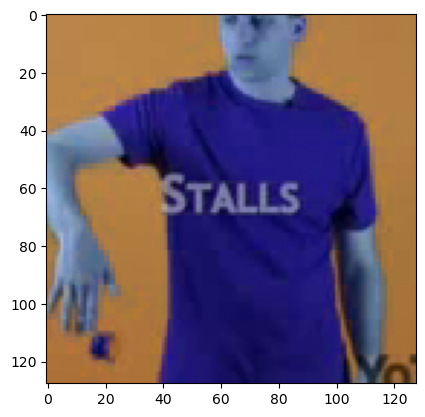

In [12]:
import numpy as np
from matplotlib import pyplot as plt
tt = np.reshape(np.loadtxt("DataFolder/Frames/test_video_frames/frame_1.txt"), (3,in_h,in_w))/255
tt = np.swapaxes(np.swapaxes(tt,0,2),0,1)
plt.imshow(tt)
plt.show()